<h1>Forecasting Air Quality in Nairobi: January 2024 Analysis </h1>


In [39]:
import pandas as pd
from pprint import PrettyPrinter #used to print data in more human-readable format 
from pymongo import MongoClient # Importing MongoClient from pymongo for interacting with MongoDB databases
import matplotlib.pyplot as plt #for visualization
import plotly.express as px #for plots
import pytz #library used in working with timezones
from sklearn.linear_model import LinearRegression #model which we are going to use
from sklearn.metrics import mean_absolute_error #for evaluation

In [40]:
# instantiate the pretty printer and giving indent 
pp = PrettyPrinter(indent = 2)

<h2> Preparing the data<h2>
   

In [41]:
# creating the client to connect to db 
client = MongoClient(host = "localhost", port = 27017)
# printing the list of db available at client
pp.pprint(list(client.list_databases()))

[ {'empty': False, 'name': 'admin', 'sizeOnDisk': 40960},
  {'empty': False, 'name': 'air-quality', 'sizeOnDisk': 47640576},
  {'empty': False, 'name': 'config', 'sizeOnDisk': 110592},
  {'empty': False, 'name': 'local', 'sizeOnDisk': 73728}]


<h3> Assigning the air-quality database to db </h3>

In [42]:
db = client["air-quality"]

In [43]:
# printing the list of collection available at db
for c in db.list_collections():
    print(c['name'])

JanNairobi
output_data


In [44]:
# assigning the collection "output_data" to nairobi
nairobi = db["output_data"]

In [45]:
nairobi_keys = nairobi.key[0]
print(nairobi_keys)

Collection(Database(MongoClient(host=['localhost:27017'], document_class=dict, tz_aware=False, connect=True), 'air-quality'), 'output_data.key.0')


In [46]:
# number of documents in nairobi
nairobi.count_documents({})

579674

In [47]:
# this will only show for only one 
result = nairobi.find_one({})
pp.pprint(result)

{ 'P2': 22.4,
  '_id': ObjectId('65ead2091775cfa69ec377c0'),
  'lat': -1.289,
  'location': 3573,
  'lon': 36.825,
  'sensor_id': 49,
  'sensor_type': 'pms5003',
  'timestamp': '2024-01-01T00:00:10.062960+00:00'}


In [48]:
# Retrieve the last input in the dataset
latest_input = nairobi.find({}).sort([('_id', -1)]).limit(3)

for document in latest_input:
    pp.pprint(document)

{ '_id': ObjectId('65ead2261775cfa69ecc5019'),
  'lat': -1.289,
  'location': 3573,
  'lon': 36.825,
  'sensor_id': 50,
  'sensor_type': 'DHT22',
  'temperature': 19.6,
  'timestamp': '2024-01-31T23:59:25.265328+00:00'}
{ '_id': ObjectId('65ead2261775cfa69ecc5018'),
  'humidity': 99.9,
  'lat': -1.289,
  'location': 3573,
  'lon': 36.825,
  'sensor_id': 50,
  'sensor_type': 'DHT22',
  'timestamp': '2024-01-31T23:59:25.265328+00:00'}
{ 'P0': 6.4,
  '_id': ObjectId('65ead2261775cfa69ecc5017'),
  'lat': -1.289,
  'location': 3573,
  'lon': 36.825,
  'sensor_id': 49,
  'sensor_type': 'pms5003',
  'timestamp': '2024-01-31T23:59:24.169254+00:00'}


In [49]:
# for distinct site  
nairobi.distinct("location")

[35, 76, 3573, 3612, 3626]

In [50]:
# counting the number of documents at each location
print("Documents from site 35:", nairobi.count_documents({"location":35}))
print("Documents from site 3573:", nairobi.count_documents({"location":3573}))
print("Documents from site 3612:", nairobi.count_documents({"location":3612}))
print("Documents from site 3626:", nairobi.count_documents({"location":3626}))
print("Documents from site 76:", nairobi.count_documents({"location":76}))


Documents from site 35: 72001
Documents from site 3573: 375573
Documents from site 3612: 67785
Documents from site 3626: 30964
Documents from site 76: 33351


<h4> we will use site 3573 as it has the most no of documents </h4>

In [51]:
# we are counting the number of reading for each measuremnt type
# Initialize counters for each measurement type
humidity_count = 0
temperature_count = 0
p0_count = 0
p1_count = 0
p2_count = 0

# Query to filter documents by location 3573
query = {"location": 3573}

# Iterate over the documents in the collection matching the query
for doc in nairobi.find(query):
    # Increment the count for each measurement type based on its presence in the document
    if 'humidity' in doc:
        humidity_count += 1
    if 'temperature' in doc:
        temperature_count += 1
    if 'P0' in doc:
        p0_count += 1
    if 'P1' in doc:
        p1_count += 1
    if 'P2' in doc:
        p2_count += 1

# Print counts
print("Count of humidity values:", humidity_count)
print("Count of temperature values:", temperature_count)
print("Count of P0 values:", p0_count)
print("Count of P1 values:", p1_count)
print("Count of P2 values:", p2_count)


Count of humidity values: 75132
Count of temperature values: 75132
Count of P0 values: 75103
Count of P1 values: 75103
Count of P2 values: 75103


In [52]:
# retreive the reading from site 3573 
result = nairobi.find(
    {"location": 3573},
    {"P2": 1, "timestamp": 1, "_id": 0}  # Projection parameter 
)
pp.pprint(result.next())


{'P2': 22.4, 'timestamp': '2024-01-01T00:00:10.062960+00:00'}


In [74]:
# read the records from results and querying it into the dataframe 
df = pd.DataFrame(result).set_index("timestamp")
df.dropna(inplace=True)
df.head()

,P2,P2.L1
timestamp,,
2024-01-01 04:00:00+03:00,20.631081,22.537019
2024-01-01 05:00:00+03:00,20.193750,20.631081
2024-01-01 06:00:00+03:00,17.472273,20.193750
2024-01-01 07:00:00+03:00,17.708796,17.472273
2024-01-01 08:00:00+03:00,16.832432,17.708796


In [72]:
# here we need to change the 
# Convert index to DateTimeIndex
df.index = pd.to_datetime(df.index)

# Convert the timezone to nairobi for the index
df.index = df.index.tz_convert("Africa/Nairobi")

In [73]:
df.head()

,P2,P2.L1
timestamp,,
2024-01-01 04:00:00+03:00,20.631081,22.537019
2024-01-01 05:00:00+03:00,20.193750,20.631081
2024-01-01 06:00:00+03:00,17.472273,20.193750
2024-01-01 07:00:00+03:00,17.708796,17.472273
2024-01-01 08:00:00+03:00,16.832432,17.708796


<h2> Visualization through plots <h2> 

<Axes: title={'center': 'Distribution of PM2.5 reading'}>

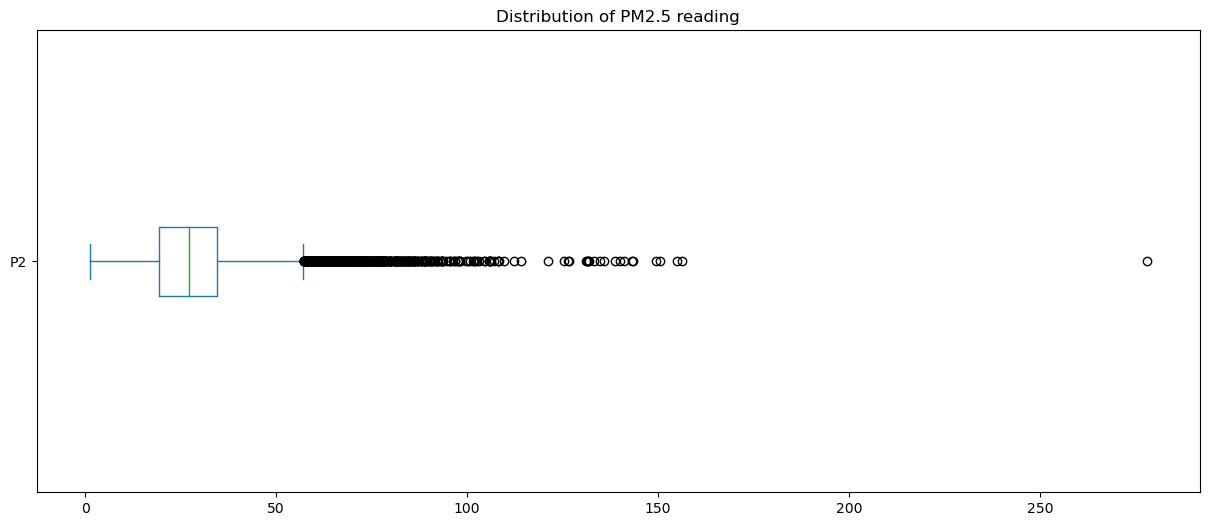

In [56]:
# plotting the box plot to visualize the oultiers present in our data

fig, ax = plt.subplots(figsize=(15, 6))
df["P2"].plot(kind = "box", vert = False, title = "Distribution of PM2.5 reading", ax = ax)

In [75]:
#Removing the outliers
df = df[df["P2"] < 500 ] 

In [57]:
#Resampling the data to hourly format and converting that data into the dataframe  and impute missing values with forward fill

df = df["P2"].resample("1H").mean().fillna(method = "ffill").to_frame()
df.head()

,P2
timestamp,
2024-01-01 03:00:00+03:00,22.537019
2024-01-01 04:00:00+03:00,20.631081
2024-01-01 05:00:00+03:00,20.193750
2024-01-01 06:00:00+03:00,17.472273
2024-01-01 07:00:00+03:00,17.708796


<Axes: title={'center': 'PM 2.5 Time Series'}, xlabel='Time', ylabel='PM 2.5'>

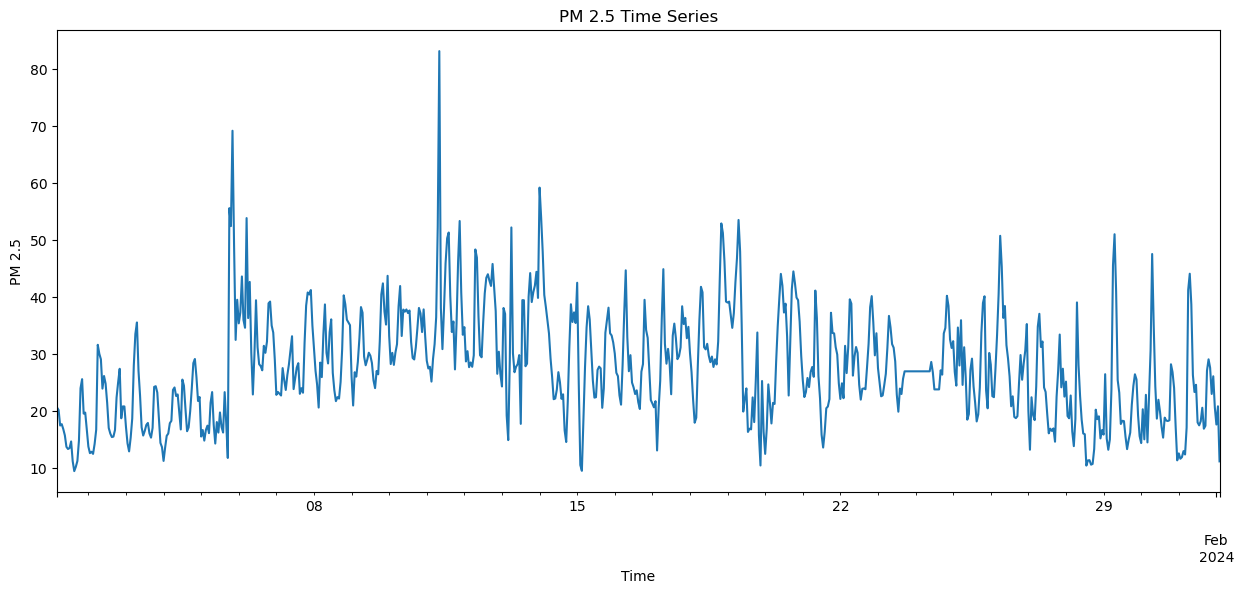

In [76]:
# plot of P2 reading of January month

fig, ax = plt.subplots(figsize=(15, 6))
df["P2"].plot(xlabel = "Time", ylabel = "PM 2.5", title = "PM 2.5 Time Series")

<Axes: title={'center': 'Weekly rolling average'}, xlabel='timestamp', ylabel='PM 2.5'>

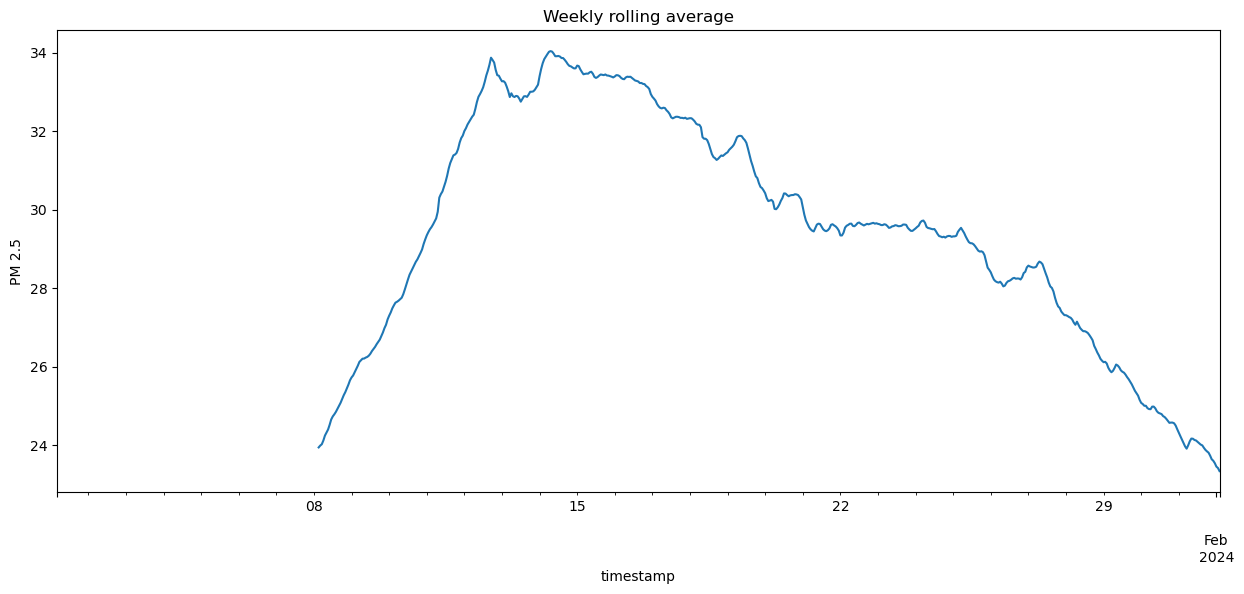

In [77]:
# weekly rolling average or moving average
# we have use rolling as 168 as it is the hours in a week.

fig, ax = plt.subplots(figsize=(15, 6))
df["P2"].rolling(168).mean().plot(ax=ax, ylabel = "PM 2.5",title = "Weekly rolling average")

<h2>Correlation</h2>

In [60]:
# we are creating this new columns inorder to find the correlation between current hour and previous hour
df["P2.L1"] = df["P2"].shift(1)
df.dropna(inplace = True)
df.head()

,P2,P2.L1
timestamp,,
2024-01-01 04:00:00+03:00,20.631081,22.537019
2024-01-01 05:00:00+03:00,20.193750,20.631081
2024-01-01 06:00:00+03:00,17.472273,20.193750
2024-01-01 07:00:00+03:00,17.708796,17.472273
2024-01-01 08:00:00+03:00,16.832432,17.708796


In [61]:
# we are finding correlation 
df.corr()

,P2,P2.L1
P2,1.000000,0.775347
P2.L1,0.775347,1.000000


Text(0.5, 1.0, 'PM 2.5 Autocorrelation')

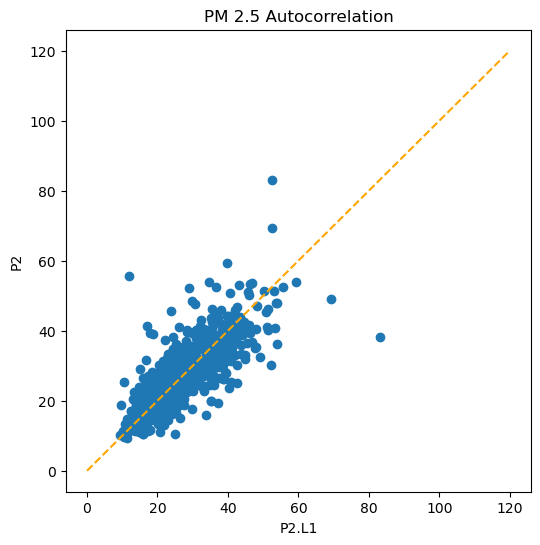

In [78]:
# scatter graph of correlation for understanding correlation in  visualization

fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(x = df["P2.L1"], y = df["P2"])
ax.plot([0,120],[0,120], linestyle = "--", color = "orange")
plt.xlabel("P2.L1")
plt.ylabel("P2")
plt.title("PM 2.5 Autocorrelation")

<h2> Splitting the data <h2>
    <h3> we are splitting the dataframe into feature and target </h3>

In [63]:
# here my target is P2 so i am assiging it to y and feature to x
target = "P2"
y = df[target]
X = df.drop(columns = target)
X.head()

,P2.L1
timestamp,
2024-01-01 04:00:00+03:00,22.537019
2024-01-01 05:00:00+03:00,20.631081
2024-01-01 06:00:00+03:00,20.193750
2024-01-01 07:00:00+03:00,17.472273
2024-01-01 08:00:00+03:00,17.708796


<h3> splitting the data into training and testing data </h3>

In [64]:
# here we are splitting 80% into training and 20% into testing data 

cutoff = int(len(X)*0.8)

X_train, y_train = X.iloc[:cutoff], y.iloc[:cutoff]
X_test, y_test = X.iloc[cutoff:], y.iloc[cutoff:]

In [65]:
# checking if our data is splitted properly and checking the count if it matches to X 
len(X_train) + len(X_test)  == len(X)

True

<h2>Building Model</h2>
<h3> Baseline <h3>

In [66]:
# Building the model
y_mean = y_train.mean()
y_pred_baseline = [y_mean] * len(y_train)
mae_baseline = mean_absolute_error(y_train, y_pred_baseline)

print("Mean P2 Reading:", round(y_train.mean(), 2))
print("Baseline MAE:", round(mae_baseline, 2))

Mean P2 Reading: 28.89
Baseline MAE: 7.3


<h3>Iterate</h3>
<h4>instantiate the linear regression model and fitting the training data</h4>

In [67]:
# training our model with Linear regression
model = LinearRegression()
model.fit(X_train, y_train)


LinearRegression()

In [68]:
# calculate the training and testing MAE for our model
training_mae = mean_absolute_error(y_train, model.predict(X_train) )
test_mae = mean_absolute_error(y_test, model.predict(X_test))
print("Training MAE:", round(training_mae, 2))
print("Test MAE:", round(test_mae, 2))

Training MAE: 4.24
Test MAE: 4.89


<h3>Creating the dataframe which contains the test data and prediction by the model</h3>

In [69]:
df_pred_test = pd.DataFrame(
    {
        "y_test":y_test,
        "y_pred":model.predict(X_test)
    }
)
df_pred_test.head()

,y_test,y_pred
timestamp,,
2024-01-25 22:00:00+03:00,20.490926,24.868417
2024-01-25 23:00:00+03:00,30.208850,22.448567
2024-01-26 00:00:00+03:00,28.166518,29.902325
2024-01-26 01:00:00+03:00,22.624312,28.335833
2024-01-26 02:00:00+03:00,22.447619,24.084898


<h3> Plotting the time series model </h3>

In [81]:
# time series line plot 
fig = px.line(df_pred_test, labels = {"value":"P2"})
fig.show()

In [ ]:
# finish